In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# Cargamos Dataset y definimos Generator

In [3]:
reduced_dataset_folder = './challenge_dataset_v3'

In [4]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [5]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy', allow_pickle=True).flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy', allow_pickle=True).flat[0]

In [6]:
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [7]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch

In [8]:
target_size=(320, 320)

In [9]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 10, classes = classes,
                                                            concat_output = False,
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = classes,
                                                              concat_output = False,
                                                              target_size=target_size
                                                         )

Found 2400 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


In [10]:
# [[images], [[one_hot], [bboxes]]]
next(train_generator_multiple_outputs)[0].shape

(10, 320, 320, 3)

In [11]:
next(train_generator_multiple_outputs)[1][0]

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [12]:
next(train_generator_multiple_outputs)[1][1]

array([[0.504     , 0.52933333, 0.328     , 0.66933333],
       [0.473     , 0.592     , 0.806     , 0.416     ],
       [0.366     , 0.53066667, 0.372     , 0.71466667],
       [0.559     , 0.38138138, 0.386     , 0.47447447],
       [0.499     , 0.35333333, 0.998     , 0.504     ],
       [0.552     , 0.48353293, 0.472     , 0.3742515 ],
       [0.585     , 0.65337423, 0.798     , 0.44171779],
       [0.66      , 0.56830601, 0.588     , 0.29508197],
       [0.472     , 0.50600601, 0.936     , 0.41141141],
       [0.535     , 0.45877378, 0.602     , 0.39323467]])

# Verificamos los datos Graficando

[0.   0.   0.   0.   0.   1.   0.   0.   0.58 0.46 0.76 0.89]


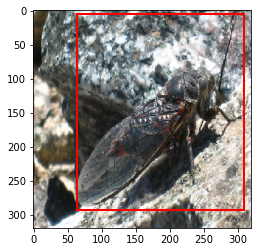

[0.   0.   0.   1.   0.   0.   0.   0.   0.28 0.51 0.48 0.72]


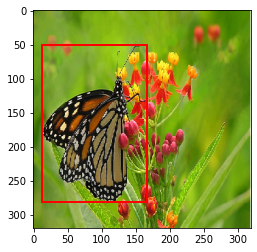

[0.   0.   0.   0.   0.   0.   1.   0.   0.46 0.43 0.21 0.85]


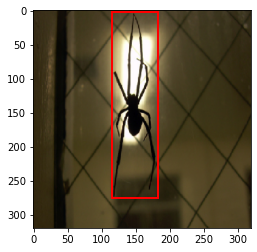

[0.   0.   0.   1.   0.   0.   0.   0.   0.16 0.59 0.33 0.68]


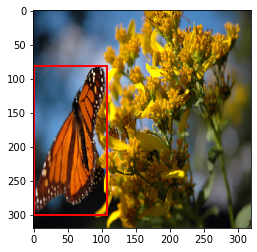

[0.   0.   0.   1.   0.   0.   0.   0.   0.47 0.49 0.46 0.39]


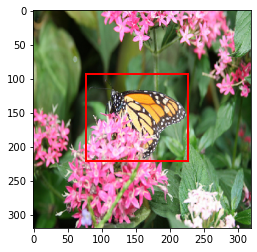

[0.   0.   0.   0.   0.   0.   1.   0.   0.59 0.5  0.42 0.99]


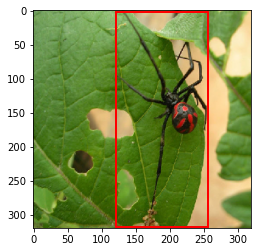

[1.   0.   0.   0.   0.   0.   0.   0.   0.55 0.43 0.38 0.48]


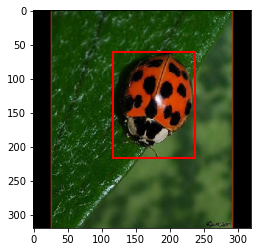

[0.   1.   0.   0.   0.   0.   0.   0.   0.61 0.46 0.68 0.78]


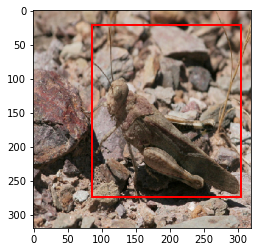

[0.   1.   0.   0.   0.   0.   0.   0.   0.43 0.35 0.69 0.61]


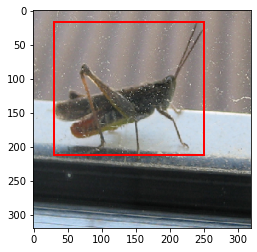

[0.   0.   0.   1.   0.   0.   0.   0.   0.48 0.3  0.33 0.56]


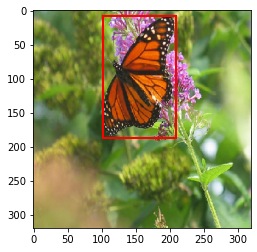

In [13]:
plot_batch(train_generator_multiple_outputs, count=10)

# Armamos modelo basado en VGG-16

In [14]:
from keras.applications.vgg16 import VGG16

In [15]:
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))

In [16]:
modelVGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0     

# Agregamos capas Densas

In [17]:
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Model

In [18]:
n_classes = len(classes)
flatten_output = Flatten()(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))
dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))

class_prediction = Dense(n_classes, activation='softmax', name='category_output')(dense_2_output)
bbox_prediction = Dense(4, activation=None, name='bounding_box')(Dropout(0.5)(dense_2_output))

model = Model(inputs=modelVGG16.input, outputs=[class_prediction, bbox_prediction])

# Seteo capas entrenable

In [19]:
N_trainable = 17
print('primer capa entrenable:', model.layers[17].name)

for layer in model.layers[:N_trainable]:
    layer.trainable = False
for layer in model.layers[N_trainable:]:
    layer.trainable = True

primer capa entrenable: block5_conv3


In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

# Metricas y función de Costo

# $L = \beta L_{categorical} + \gamma L_{boundingbox}$

# IoU (Intersección Over Union) o Indice de Jaccard

Ratio entre la union de las bounding boxes y la intersección

In [22]:
from custom_losses import IOU_loss, iou, set_classes

In [23]:
set_classes(n_classes)

In [24]:
losses = {"category_output": "categorical_crossentropy", 
          "bounding_box": "mean_squared_error"
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  20.0,
              }

In [25]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 50, classes = classes,
                                                            concat_output = False,
                                                            flip = 'random',
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 50, classes = classes,
                                                              concat_output = False,
                                                              flip = 'random',
                                                          target_size=target_size
                                                         )

Found 2400 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


In [27]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='bounding_box_IOU_loss', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

In [28]:
from object_detection_helper import PlotLosses

### Esto puede tardar alrededor de una hora asi que siga adelante con la siguiente práctica mientras tanto

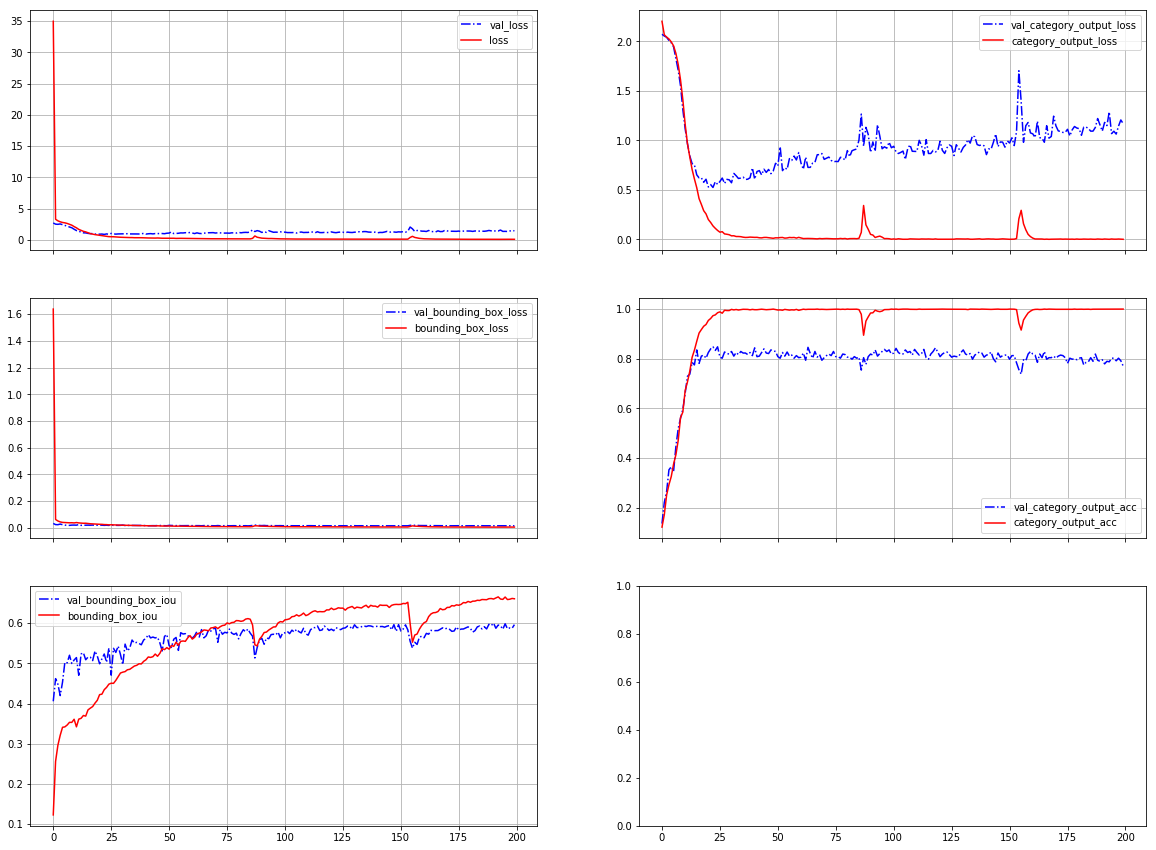

In [ ]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [ ]:
model.load_weights('runtime_best.hdf5')

In [ ]:
model.evaluate_generator(val_generator_multiple_outputs)

[1.4379295607407887,
 1.1142579143246014,
 0.01618358261960869,
 0.7854166701436043,
 0.588404044508934,
 0.4115959492822488]

Class OK: 5
IOU: [0.91187205]


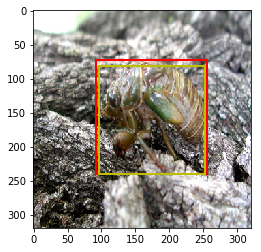

Class Failed: 2 1
IOU: [0.76677324]


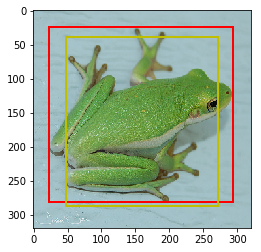

Class OK: 5
IOU: [0.55524115]


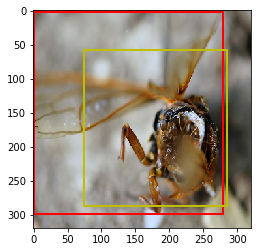

Class OK: 3
IOU: [0.52536519]


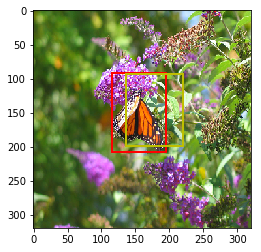

Class OK: 3
IOU: [0.67991387]


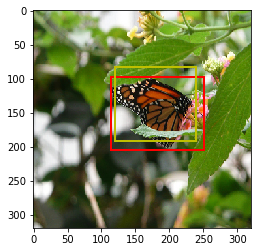

Class OK: 2
IOU: [0.6775046]


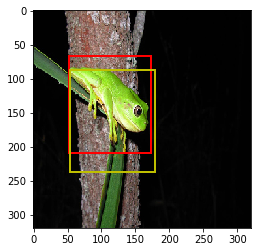

Class OK: 3
IOU: [0.76588672]


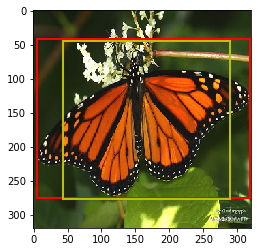

Class OK: 3
IOU: [0.11655769]


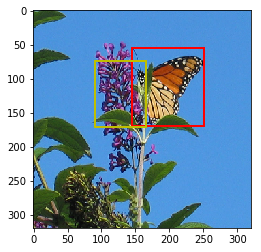

Class Failed: 7 5
IOU: [0.33604449]


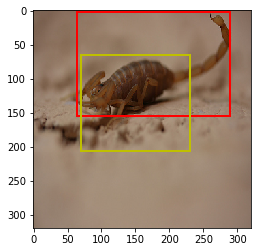

Class OK: 1
IOU: [0.55415081]


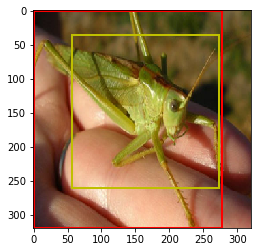

In [ ]:
plot_batch(val_generator_multiple_outputs, model, count=10)